In [1]:
import torch
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("USING device :",device)
print(torch.cuda.get_device_name(0))

USING device : cuda
NVIDIA A100-SXM4-80GB


# Configuration

In [2]:
import numpy as np
import os
# from sklearn.preprocessing import LabelEncoder
import cv2
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
from torchvision.transforms import functional as func

In [3]:
class Config:
    batch_size = 128
    num_epochs = 50
    lr = 1e-4
    num_source_domains = 5  # 0°, 30°, 60°
    source_domains = [15, 30, 45, 60, 75]
    target_domains = [0, 90]       # Unseen domain
    train_classes = [0,1,2,3,4,5,6,7,8]
    num_classes = 9                # Using number 9 as the unseen class

config = Config()

In [4]:
class RotatedMNIST(Dataset):
    def __init__(self, base_dataset, rotation_angles, indices):
        self.base_dataset = base_dataset
        self.rotation_angles = rotation_angles
        self.transform = transforms.ToTensor()

        if indices is not None:
            self.indices = indices
        else:
            self.indices = torch.arange(len(self.base_dataset))

    def __getitem__(self, index):
        real_index = self.indices[index]
        img, label = self.base_dataset[real_index]  
        rot = random.choice(self.rotation_angles)

        # Make sure img is a PIL Image
        if not hasattr(img, "rotate"):
            img = transforms.ToPILImage()(img)

        img = func.rotate(img, rot)
        img = self.transform(img)

        if rot == 0:
            domain = 6
        else:
            domain = int(rot / 15 - 1)

        return img, domain, label

    def __len__(self):
        return len(self.indices)

In [5]:
class RotatedDomainMNIST(Dataset):
    def __init__(self, base_dataset, rotation_angle, indices):
        self.base_dataset = base_dataset
        self.rotation_angle = rotation_angle
        self.transform = transforms.ToTensor()

        if indices is not None:
            self.indices = indices
        else:
            self.indices = torch.arange(len(self.base_dataset))

    def __getitem__(self, index):
        real_index = self.indices[index]
        img, label = self.base_dataset[real_index]  

        # Make sure img is a PIL Image
        if not hasattr(img, "rotate"):
            img = transforms.ToPILImage()(img)

        img = func.rotate(img, self.rotation_angle)
        img = self.transform(img)

        if self.rotation_angle == 0:
            domain = 6
        else:
            domain = int(self.rotation_angle / 15 - 1)

        return img, label, domain

    def __len__(self):
        return len(self.indices)

In [6]:
# Load base MNIST
train_base = torchvision.datasets.MNIST(root='~/bhavyaaa/datasets', train=True, download=False)
test_base = torchvision.datasets.MNIST(root='~/bhavyaaa/datasets', train=False, download=False)

In [7]:
train_indices = (train_base.targets != 9).nonzero().flatten()
test_indices = (test_base.targets != 9).nonzero().flatten()
unseen_train_indices = (train_base.targets == 9).nonzero().flatten()
unseen_test_indices = (test_base.targets == 9).nonzero().flatten()

In [8]:
dTrain_dataset = RotatedMNIST(train_base, config.source_domains, indices = train_indices)
cTrain_datasets = {dom: RotatedDomainMNIST(train_base, dom, indices = train_indices) for dom in config.source_domains}

test_dataset = RotatedMNIST(test_base, config.target_domains, indices = test_indices)  # Unseen domain
unseen_test_dataset = RotatedMNIST(test_base, config.target_domains, indices = unseen_test_indices)
unseen_train_dataset = RotatedMNIST(train_base, config.source_domains, indices = unseen_train_indices)

In [9]:
dTrain_loader = DataLoader(dTrain_dataset, batch_size = config.batch_size, shuffle=True, num_workers=2)
cTrain_loaders = {dom: DataLoader(cTrain_datasets[dom], batch_size = config.batch_size, shuffle=True, num_workers=2)
                    for dom in config.source_domains}

test_loader = DataLoader(test_dataset, batch_size = config.batch_size, shuffle=True, num_workers=2)
unseen_train_loader = DataLoader(unseen_train_dataset, batch_size = config.batch_size, shuffle=True, num_workers=2)
unseen_test_loader = DataLoader(unseen_test_dataset, batch_size = config.batch_size, shuffle=True, num_workers=2)

# Definitions

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from PIL import Image

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (32, 128, 128)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # (32, 64, 64)
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   # (64, 64, 64)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # (64, 32, 32)
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (128, 32, 32)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)          # (128, 16, 16)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        # Flatten the feature maps: alternative to x = x.view(x.size(0), -1)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x


# Model Training

In [12]:
print("Domain model num_classes:", len(config.source_domains))


Domain model num_classes: 5


In [13]:
domain_model = SimpleCNN(num_classes=len(config.source_domains)).to(device)
class_models = {dom:SimpleCNN(num_classes=len(config.train_classes)).to(device) for dom in config.source_domains}

In [14]:
num_epochs = 20
def Trainer(num_epochs, learning_rate, weight_d, model, train_loader, train_dataset):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_d)
    # Optionally, add a learning rate scheduler:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels, _ in train_loader:
            images=images.to(device)
            #labels = torch.tensor(labels)
            labels=labels.to(device)
            
            optimizer.zero_grad()
            #print("Labels:", labels.min().item(), labels.max().item())
            outputs = model(images)
            #print("Output shape:", outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_dataset)
        if (epoch+1)%5==0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
        # Update scheduler if using one
        scheduler.step(epoch_loss)

In [15]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [16]:
print("Domain Classifier")
Trainer(num_epochs, 0.001, 1e-5, domain_model, dTrain_loader, dTrain_dataset)

Domain Classifier
Epoch [5/20], Loss: 0.0327
Epoch [10/20], Loss: 0.0097
Epoch [15/20], Loss: 0.0048
Epoch 00019: reducing learning rate of group 0 to 5.0000e-04.
Epoch [20/20], Loss: 0.0016


In [17]:
for dom in config.source_domains:
    print(dom," Classifier")
    Trainer(20, 0.0001, 1e-5, class_models[dom], cTrain_loaders[dom], cTrain_datasets[dom])

15  Classifier
Epoch [5/20], Loss: 0.0873
Epoch [10/20], Loss: 0.0507
Epoch [15/20], Loss: 0.0356
Epoch [20/20], Loss: 0.0279
30  Classifier
Epoch [5/20], Loss: 0.0826
Epoch [10/20], Loss: 0.0498
Epoch [15/20], Loss: 0.0361
Epoch [20/20], Loss: 0.0269
45  Classifier
Epoch [5/20], Loss: 0.0861
Epoch [10/20], Loss: 0.0515
Epoch [15/20], Loss: 0.0361
Epoch [20/20], Loss: 0.0272
60  Classifier
Epoch [5/20], Loss: 0.0930
Epoch [10/20], Loss: 0.0538
Epoch [15/20], Loss: 0.0394
Epoch [20/20], Loss: 0.0290
75  Classifier
Epoch [5/20], Loss: 0.0840
Epoch [10/20], Loss: 0.0497
Epoch [15/20], Loss: 0.0363
Epoch [20/20], Loss: 0.0265


# **MODEL EVALUATION**

1. CLASSIFICATION REPORT USING SEG_TEST
2. CONFUSION MATRIX

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch.nn.functional as F

In [19]:
def entropy(cls_prob):
    score = -torch.sum(cls_prob * torch.log(cls_prob.clamp(min=1e-12)), dim=1)
    return score

In [20]:
def ModelChecker(model, test_loader, class_names):
    model.eval()
    all_preds=[]
    all_labels=[]
    all_certs=[]
    all_uncerts=[]

    with torch.no_grad():
        for images,_,labels in test_loader:
            images=images.to(device)
            labels= labels.to(device)
            outputs= model(images)
            probs = F.softmax(outputs, dim=1)
            certs,preds = torch.max(probs,1)
            all_certs.extend(certs.cpu().numpy())
            #_,preds=torch.max(outputs,1)
            uncerts = entropy(probs)
            all_uncerts.extend(uncerts.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds=np.array(all_preds)
    all_labels=np.array(all_labels)
    all_certs=np.array(all_certs)
    all_uncerts=np.array(all_uncerts)

    report= classification_report(all_labels,all_preds,target_names=class_names)
    print("classification report:\n",report)

    conf_matrix= confusion_matrix(all_labels,all_preds)
    # print("Confusion Matrix:\n",conf_matrix)

    correct_mask = all_preds == all_labels
    incorrect_mask = ~correct_mask

    # -------------------------------
    # Set up the figure
    # -------------------------------
    fig = plt.figure(figsize=(16, 12))
    grid = GridSpec(3, 2, height_ratios=[1.2, 1, 1])

    ax0 = fig.add_subplot(grid[0, :])
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot(ax=ax0, cmap='Blues', values_format='d', colorbar=False)
    ax0.set_title('Confusion Matrix')

    ax1 = fig.add_subplot(grid[1, 0])
    sns.histplot(all_certs[correct_mask], bins=30, kde=True, color='green', ax=ax1)
    ax1.set_title('Certainty — Correct Predictions')
    ax1.set_xlabel('Certainty')
    ax1.set_ylabel('Count')

    ax2 = fig.add_subplot(grid[1, 1])
    sns.histplot(all_certs[incorrect_mask], bins=30, kde=True, color='red', ax=ax2)
    ax2.set_title('Certainty — Incorrect Predictions')
    ax2.set_xlabel('Certainty')
    ax2.set_ylabel('Count')

    ax3 = fig.add_subplot(grid[2, 0])
    sns.histplot(all_uncerts[correct_mask], bins=30, kde=True, color='blue', ax=ax3)
    ax3.set_title('Uncertainty — Correct Predictions')
    ax3.set_xlabel('Uncertainty')
    ax3.set_ylabel('Count')

    ax4 = fig.add_subplot(grid[2, 1])
    sns.histplot(all_uncerts[incorrect_mask], bins=30, kde=True, color='orange', ax=ax4)
    ax4.set_title('Uncertainty — Incorrect Predictions')
    ax4.set_xlabel('Uncertainty')
    ax4.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

In [21]:
def CompleteChecker(domain_model, class_models, test_loader, train_domain_names, class_names):
    domain_model.eval()
    for dom in train_domain_names:
        class_models[dom].eval()

    all_preds=[]
    all_labels=[]
    all_certs=[]
    all_uncerts=[]

    with torch.no_grad():
        for images,_,labels in test_loader:
            images=images.to(device)
            labels= labels.to(device)

            dom_outputs= domain_model(images)
            dom_probs = F.softmax(dom_outputs, dim=1)

            class_outputs = {}
            class_probs = {}
            for dom in train_domain_names:
                class_outputs[dom] = class_models[dom](images)
                class_probs[dom] = F.softmax(class_outputs[dom], dim=1)
            
            probs = torch.zeros_like(next(iter(class_probs.values())))
            for idx, dom in enumerate(train_domain_names):
                weight = dom_probs[:, idx].unsqueeze(1)
                probs += weight * class_probs[dom]

            certs,preds = torch.max(probs,1)
            uncerts = entropy(probs)

            all_certs.extend(certs.cpu().numpy())
            all_uncerts.extend(uncerts.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds=np.array(all_preds)
    all_labels=np.array(all_labels)
    all_certs=np.array(all_certs)
    all_uncerts=np.array(all_uncerts)

    report= classification_report(all_labels,all_preds,target_names=class_names)
    print("classification report:\n",report)

    conf_matrix= confusion_matrix(all_labels,all_preds)
    #print("Confusion Matrix:\n",conf_matrix)

    correct_mask = all_preds == all_labels
    incorrect_mask = ~correct_mask

    # -------------------------------
    # Set up the figure
    # -------------------------------
    fig = plt.figure(figsize=(16, 12))
    grid = GridSpec(3, 2, height_ratios=[1.2, 1, 1])

    ax0 = fig.add_subplot(grid[0, :])
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot(ax=ax0, cmap='Blues', values_format='d', colorbar=False)
    ax0.set_title('Confusion Matrix')

    ax1 = fig.add_subplot(grid[1, 0])
    sns.histplot(all_certs[correct_mask], bins=30, kde=True, color='green', ax=ax1)
    ax1.set_title('Certainty — Correct Predictions')
    ax1.set_xlabel('Certainty')
    ax1.set_ylabel('Count')

    ax2 = fig.add_subplot(grid[1, 1])
    sns.histplot(all_certs[incorrect_mask], bins=30, kde=True, color='red', ax=ax2)
    ax2.set_title('Certainty — Incorrect Predictions')
    ax2.set_xlabel('Certainty')
    ax2.set_ylabel('Count')

    ax3 = fig.add_subplot(grid[2, 0])
    sns.histplot(all_uncerts[correct_mask], bins=30, kde=True, color='blue', ax=ax3)
    ax3.set_title('Uncertainty — Correct Predictions')
    ax3.set_xlabel('Uncertainty')
    ax3.set_ylabel('Count')

    ax4 = fig.add_subplot(grid[2, 1])
    sns.histplot(all_uncerts[incorrect_mask], bins=30, kde=True, color='orange', ax=ax4)
    ax4.set_title('Uncertainty — Incorrect Predictions')
    ax4.set_xlabel('Uncertainty')
    ax4.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

# Testing Data Preparation

# Model Testing

classification report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.98      0.96      0.97      1135
           2       0.89      0.93      0.91      1032
           3       0.98      0.94      0.96      1010
           4       0.89      0.93      0.91       982
           5       0.87      0.92      0.89       892
           6       0.96      0.87      0.91       958
           7       0.91      0.90      0.91      1028
           8       0.97      0.94      0.95       974

    accuracy                           0.93      8991
   macro avg       0.93      0.93      0.93      8991
weighted avg       0.93      0.93      0.93      8991



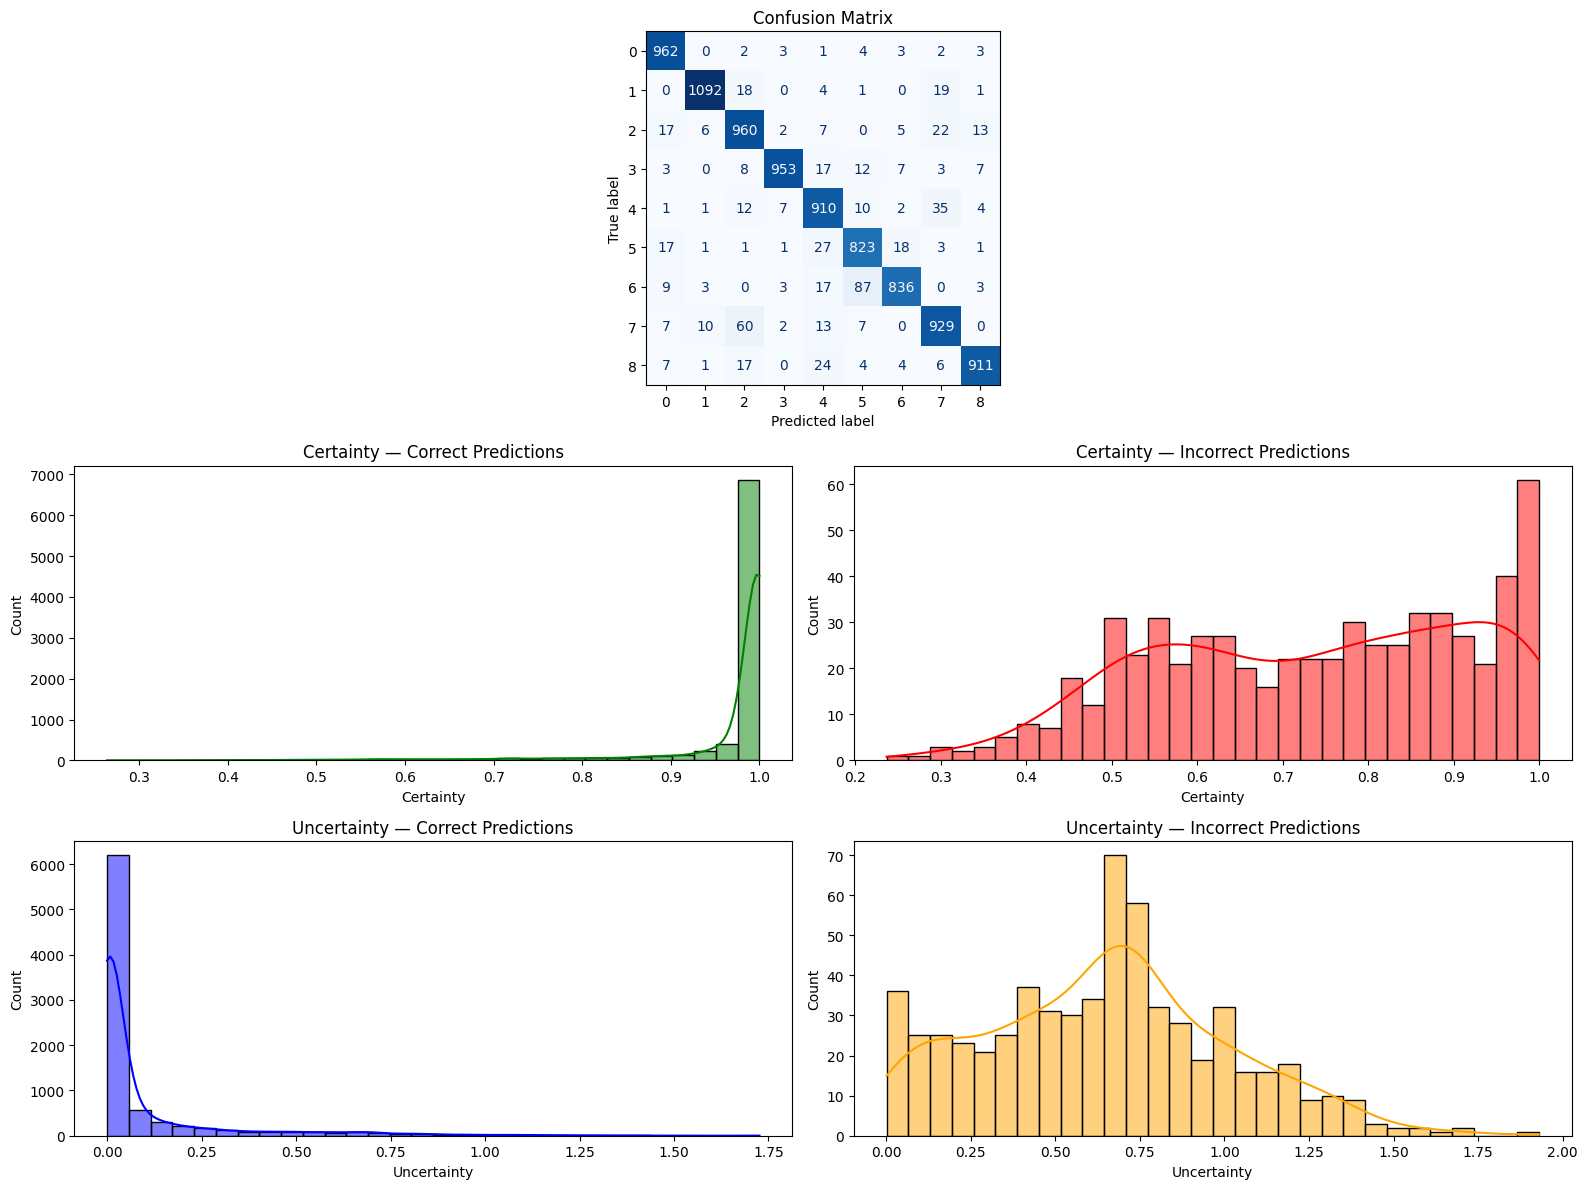

In [22]:
CompleteChecker(domain_model, class_models, test_loader, config.source_domains, ["0","1","2","3","4","5","6","7","8"])

# Unseen Testing

In [23]:
def UnseenChecker(domain_model, class_models, test_loader, train_domain_names):
    domain_model.eval()
    for dom in train_domain_names:
        class_models[dom].eval()

    all_preds=[]
    all_certs=[]
    all_uncerts=[]

    with torch.no_grad():
        for images,_,_ in test_loader:
            images=images.to(device)

            dom_outputs= domain_model(images)
            dom_probs = F.softmax(dom_outputs, dim=1)

            class_outputs = {}
            class_probs = {}
            for dom in train_domain_names:
                class_outputs[dom] = class_models[dom](images)
                class_probs[dom] = F.softmax(class_outputs[dom], dim=1)
            
            probs = torch.zeros_like(next(iter(class_probs.values())))
            for idx, dom in enumerate(train_domain_names):
                weight = dom_probs[:, idx].unsqueeze(1)
                probs += weight * class_probs[dom]

            certs,preds = torch.max(probs,1)
            uncerts = entropy(probs)

            all_certs.extend(certs.cpu().numpy())
            all_uncerts.extend(uncerts.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_preds=np.array(all_preds)
    all_certs=np.array(all_certs)
    all_uncerts=np.array(all_uncerts)

    # -------------------------------
    # Set up the figure
    # -------------------------------
    fig = plt.figure(figsize=(16, 12))
    grid = GridSpec(3, 2, height_ratios=[1.2, 1, 1])


    ax1 = fig.add_subplot(grid[1, 0])
    sns.histplot(all_certs, bins=30, kde=True, color='green', ax=ax1)
    ax1.set_title('Certainty')
    ax1.set_xlabel('Certainty')
    ax1.set_ylabel('Count')

    ax2 = fig.add_subplot(grid[1, 1])
    sns.histplot(all_certs, bins=9, kde=True, color='red', ax=ax2)
    ax2.set_title('Predictions')
    ax2.set_xlabel('Predictions')
    ax2.set_ylabel('Count')

    ax3 = fig.add_subplot(grid[2, 0])
    sns.histplot(all_uncerts, bins=30, kde=True, color='blue', ax=ax3)
    ax3.set_title('Uncertainty')
    ax3.set_xlabel('Uncertainty')
    ax3.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

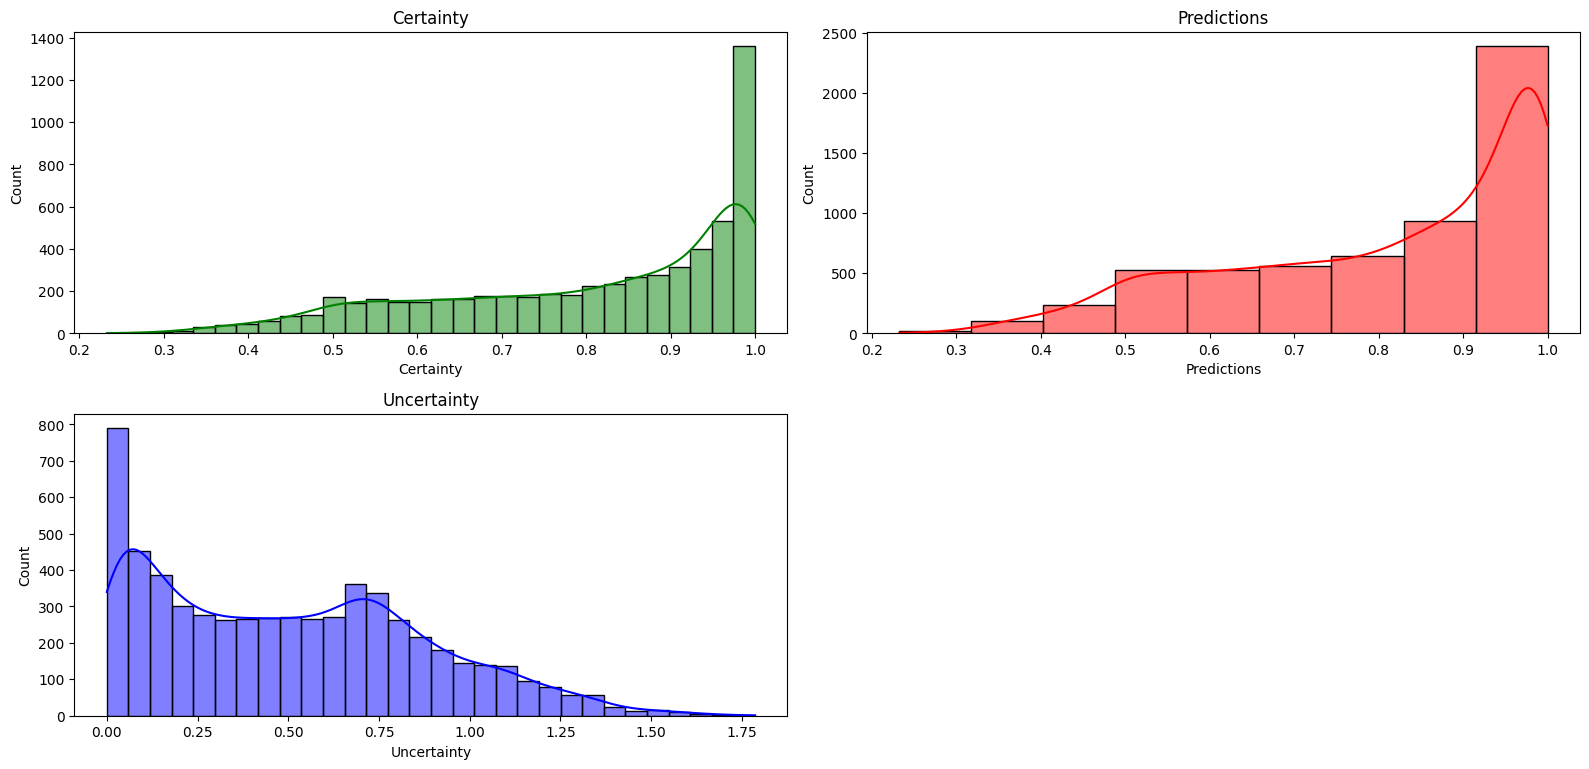

In [24]:
UnseenChecker(domain_model, class_models, unseen_train_loader, config.source_domains)

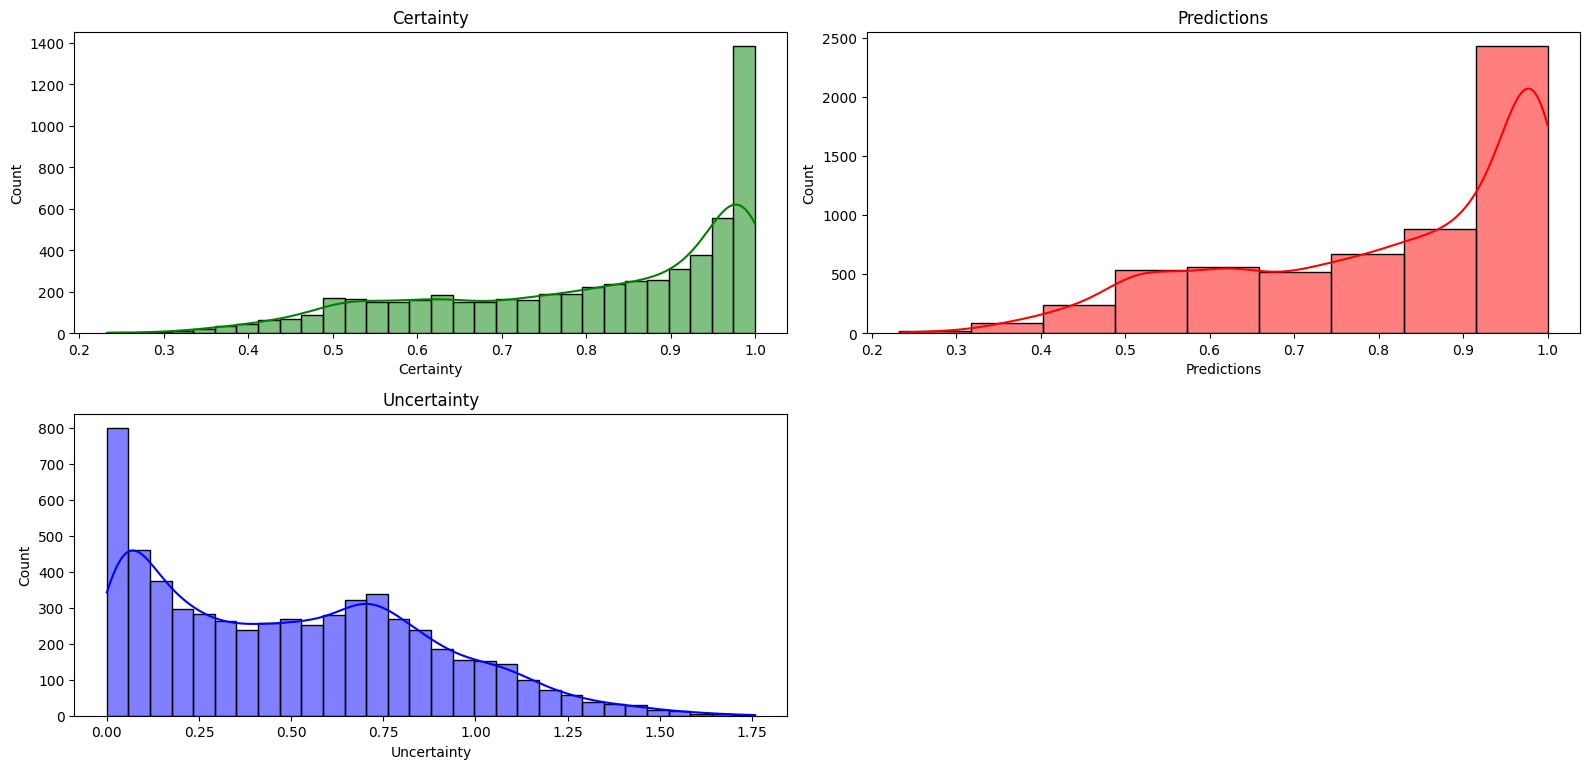

In [25]:
UnseenChecker(domain_model, class_models, unseen_train_loader, config.source_domains)

# extras

In [ ]:
# image_paths = []
# image_labels = []
# for d in range(len(eval_domains)):
#     domain = eval_domains[d]
#     for c in range(len(train_classes)):
#         clas = train_classes[c]
#         directory_path = os.path.join(data_path, domain, clas)
#         for file_name in os.listdir(directory_path):
#             file_path = os.path.join(directory_path, file_name)
#             image_paths.append(file_path)
#             image_labels.append(c)

In [ ]:
# pred_path = "../datasets/office31/webcam/bike/frame_0001.jpg"

In [ ]:
# # Move model and image tensor to the device (GPU if available)
# def CompleteEvaluator(img_paths, labels, domain_model=domain_model, class_models=class_models, domain_labels=train_domains, class_labels=train_classes):
#     domain_model.to(device)
#     domain_model.eval()
    

#     for dom in domain_labels:
#         class_models[dom].to(device)
#         class_models[dom].eval()

#     for i in range(len(img_paths)):
#         img = Image.open(img_paths[i]).convert("RGB")

#         transform = transforms.Compose([
#             transforms.Resize((128, 128)),  # Resize to 128x128
#             transforms.ToTensor(),          
#         ])

#         img_tensor = transform(img).unsqueeze(0)
#         img_tensor = img_tensor.to(device)

#         # Evaluate the model on the image
#         with torch.no_grad():
#             preds = []
#             certs = []
#             uncerts = []
#             #AttributeError: 'CustomDataset' object has no attribute 'size'
#             dom_output = domain_model(img_tensor)
#             dom_probs = F.softmax(dom_output, dim=1)
#             j = 0
#             dom = domain_labels[j]
#             class_output = class_models[dom](img_tensor)
#             class_probs = F.softmax(class_output, dim=1)
#             actual_probs = dom_probs[0][j] * class_probs
#             for j in range(1, len(dom_probs[0])):
#                 dom = domain_labels[j]
#                 class_output = class_models[dom](img_tensor)
#                 class_probs = F.softmax(class_output, dim=1)
#                 actual_probs += dom_probs[0][j] * class_probs
#             uncert = entropy(actual_probs)
#             cert, pred = torch.max(actual_probs, dim=1)
#             uncerts.append(uncert)
#             certs.append(cert)
#             preds.append(pred)

#     preds = torch.cat(preds, dim=0).cpu().numpy()
#     certs = torch.cat(certs, dim=0).cpu().numpy()
#     uncerts = torch.tensor(uncerts).cpu().numpy()

#     correct_mask = preds == labels
#     incorrect_mask = ~correct_mask

#     # -------------------------------
#     # Set up the figure
#     # -------------------------------
#     fig = plt.figure(figsize=(16, 12))
#     grid = GridSpec(3, 2, height_ratios=[1.2, 1, 1])


#     ax1 = fig.add_subplot(grid[1, 0])
#     sns.histplot(certs[correct_mask], bins=30, kde=True, color='green', ax=ax1)
#     ax1.set_title('Certainty — Correct Predictions')
#     ax1.set_xlabel('Certainty')
#     ax1.set_ylabel('Count')

#     ax2 = fig.add_subplot(grid[1, 1])
#     sns.histplot(certs[incorrect_mask], bins=30, kde=True, color='red', ax=ax2)
#     ax2.set_title('Certainty — Incorrect Predictions')
#     ax2.set_xlabel('Certainty')
#     ax2.set_ylabel('Count')

#     ax3 = fig.add_subplot(grid[2, 0])
#     sns.histplot(uncerts[correct_mask], bins=30, kde=True, color='blue', ax=ax3)
#     ax3.set_title('Uncertainty — Correct Predictions')
#     ax3.set_xlabel('Uncertainty')
#     ax3.set_ylabel('Count')

#     ax4 = fig.add_subplot(grid[2, 1])
#     sns.histplot(uncerts[incorrect_mask], bins=30, kde=True, color='orange', ax=ax4)
#     ax4.set_title('Uncertainty — Incorrect Predictions')
#     ax4.set_xlabel('Uncertainty')
#     ax4.set_ylabel('Count')

#     plt.tight_layout()
#     plt.show()
#     return 

In [ ]:
# CompleteEvaluator(image_paths, image_labels)

In [ ]:
# # Move model and image tensor to the device (GPU if available)
# def Evaluator(model, img_path, labels):
#     img = Image.open(img_path).convert("RGB")

#     transform = transforms.Compose([
#         transforms.Resize((128, 128)),  # Resize to 128x128
#         transforms.ToTensor(),          
#     ])

#     img_tensor = transform(img).unsqueeze(0)
#     model.to(device)
#     img_tensor = img_tensor.to(device)

#     # Evaluate the model on the image
#     model.eval()
#     with torch.no_grad():
#         #AttributeError: 'CustomDataset' object has no attribute 'size'
#         output = model(img_tensor)
#         print(type(output), output)
#         probs = F.softmax(output, dim=1)
#         print(probs)
#         _, predicted = torch.max(output, dim=1)

#     predicted_label = predicted.item()
#     print(predicted_label, labels[predicted_label])
#     return 

In [ ]:
# # Move model and image tensor to the device (GPU if available)
# def CompleteEvaluator(domain_model, class_models, img_tensor, train_domains, train_classes):
#     domain_model.to(device)
#     img_tensor = img_tensor.to(device)

#     # Evaluate the domain model on the image
#     domain_model.eval()
#     with torch.no_grad():
#         #AttributeError: 'CustomDataset' object has no attribute 'size'
#         domain_logits = domain_model(img_tensor)
#         print(type(output), output)
#         _, predicted = torch.max(output, 1)

#     predicted_label = predicted.item()
#     print(predicted_label, labels[predicted_label])

In [ ]:
# Evaluator(domain_model, pred_path, train_domains)

In [ ]:
# abc = torch.tensor([[ 1.0424, -1.1186]])
# cdef = torch.tensor([[ 1.0424, -1.1186]])
# abc[0][1]*cdef

In [ ]:
# Evaluator(class_models["amazon"], img_tensor, train_classes)

In [ ]:
# Evaluator(class_models["dslr"], img_tensor, train_classes)

In [ ]:
# import numpy as np

In [ ]:
# dom_logits = [0.0017, 0.1803]
# dom_probs = [0.4555, 0.5445]

# amazon_logits = np.array([-1.6326, -2.8096, -1.0975, -2.1476, -0.9902, -3.5406, -5.9390,  0.2154,
#          -0.2974, -0.2006, -1.3874, -2.7867, -2.8676, -1.9978, -2.6757, -3.6056,
#          -0.0799, -0.5774, -0.4301, -0.5248,  0.1537, -3.4979, -4.4339,  1.0425,
#          -0.9316, -1.7128, -0.6711, -0.7449, -2.5976])
# amazon_probs = np.array([1.5129e-02, 4.6628e-03, 2.5836e-02, 9.0398e-03, 2.8764e-02, 2.2450e-03,
#          2.0398e-04, 9.6029e-02, 5.7506e-02, 6.3351e-02, 1.9333e-02, 4.7711e-03,
#          4.4003e-03, 1.0501e-02, 5.3311e-03, 2.1036e-03, 7.1475e-02, 4.3462e-02,
#          5.0361e-02, 4.5809e-02, 9.0283e-02, 2.3429e-03, 9.1883e-04, 2.1958e-01,
#          3.0498e-02, 1.3965e-02, 3.9574e-02, 3.6757e-02, 5.7643e-03])

# dslr_logits = np.array([ 0.4455,  5.0423, -3.3687,  0.4425, -5.1732, -2.7109,  4.9851, -2.2462,
#          -0.7672,  3.9686, -1.5845, -0.6298, -0.7301, -1.5858, -2.7337, -3.6440,
#          -0.3399, -2.1625, -2.1451, -0.9787, -1.1209,  0.2564, -1.6166, -0.8977,
#          -2.3688, -3.3043,  0.4179,  1.2234,  0.3381])
# dslr_probs = np.array([4.2280e-03, 4.1931e-01, 9.3249e-05, 4.2156e-03, 1.5345e-05, 1.8003e-04,
#          3.9597e-01, 2.8652e-04, 1.2575e-03, 1.4328e-01, 5.5527e-04, 1.4426e-03,
#          1.3049e-03, 5.5457e-04, 1.7597e-04, 7.0807e-05, 1.9277e-03, 3.1153e-04,
#          3.1700e-04, 1.0177e-03, 8.8281e-04, 3.4997e-03, 5.3777e-04, 1.1036e-03,
#          2.5347e-04, 9.9458e-05, 4.1128e-03, 9.2040e-03, 3.7976e-03])

In [ ]:
# np.argmax(dslr_logits)

In [ ]:
# np.argmax(0.0017*amazon_logits + 0.1803*dslr_logits)

In [ ]:
# 0.4555*amazon_probs + 0.5445*dslr_probs

In [ ]:
# np.argmax(0.0017*amazon_logits + 0.1803*dslr_logits)

In [ ]:
# prob_score = torch.tensor([[0.00919341, 0.2304382 , 0.01181907, 0.00641302, 0.01311036,
#        0.00112062, 0.21569858, 0.04389722, 0.02687869, 0.10687234,
#        0.00910853, 0.00295873, 0.00271485, 0.00508517, 0.00252413,
#        0.00099674, 0.0336065 , 0.01996657, 0.02311204, 0.02142014,
#        0.0416046 , 0.00297278, 0.00071134, 0.1006196 , 0.01402985,
#        0.00641521, 0.02026538, 0.02175439, 0.00469343]])
# uncertainty = entropy(prob_score)
# uncertainty

In [ ]:
# len(prob_score[0])

In [ ]:
# max_uncert = torch.tensor([[1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29,
#                             1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29,
#                             1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29]])
# entropy(max_uncert)

In [ ]:
# max_cert = torch.tensor([[0,0,0,0,0,0,0,0,0,0,
#                           0,0,0,0,0,0,0,0,0,0,
#                           0,0,0,0,0,0,0,0,1]])
# entropy(max_cert)